In [7]:
import json
import astropy.units as u
import matplotlib.pyplot as plt

from gammapy.datasets import MapDataset
from gammapy.modeling.models import Models
from gammapy.estimators import ExcessMapEstimator

from modules.variables import *

# Specify the folder containing your JSON files
diffuse = 'no_diffuse'
file_name = 'all_IDs'
e_min = 0.7
e_max = 100
bin = 20
binsz = 0.02
jsons_path = path_to_results / diffuse / f"{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}" / "jsons"

# Initialize empty lists to store the data for plotting
names = []
values = []


In [8]:
# Iterate through the JSON files in the folder
for file_path in jsons_path.glob('*.json'):
    # Load the JSON data from the file
    with file_path.open('r') as file:
        data = json.load(file)

        # Extract the relevant data
        name = list(data.keys())[0]
        value = data[name]['cygnus_diffuse']['result'][-1]

        # Append the data to the lists
        names.append(name)
        values.append(value)


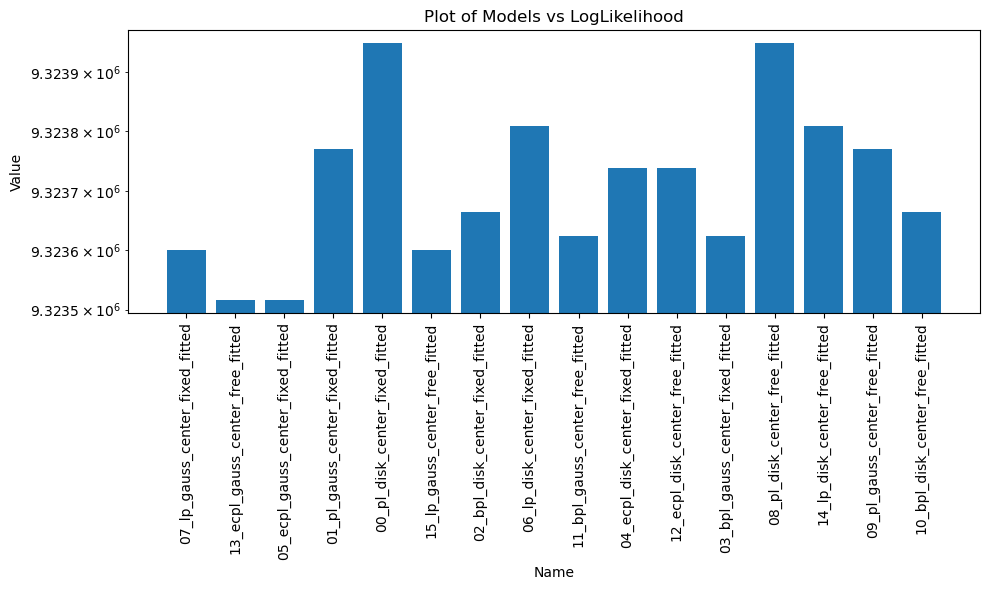

In [9]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(names, values)
plt.yscale('log')
plt.xlabel('Name')
plt.ylabel('Value')
plt.title('Plot of Models vs LogLikelihood')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Set the path to the dataset file
dataset_name = f"dataset_{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}.fits.gz"
path_to_dataset = path_to_datasets / 'width_22x10' / dataset_name

# Reading the MapDataset from the specified file
dataset = MapDataset.read(filename=path_to_dataset)

In [ ]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[1, 5, 10, 20, 50, 100] * u.TeV,
)

In [ ]:
original_model_path = dc_folder / 'skymodel' / 'global_skymodel_v1.0.yaml'
original_model = Models.read(original_model_path)

dataset.models = original_model
fermi_spatial_model = dataset.models["fermi bubble"].spatial_model
true_result = estimator.run(dataset)

# Name of the YAML file containing the fitted model to be used for the SED calculation
filename = names[values.index(max(values))]
path_to_fit_models = path_to_results / diffuse / f"{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}" / "models"

# Load the fitted model from the YAML file
models_fit = Models.read(f"{path_to_fit_models}/{filename}.yaml")

# Set the loaded model as the source model in the dataset
dataset.models = models_fit
cygnus_diffuse_spatial_model = dataset.models["cygnus_diffuse"].spatial_model
diffuse_result = estimator.run(dataset)

plt.figure(figsize=(15, 5))
true_result["sqrt_ts"].sum_over_axes().plot(cmap="coolwarm", add_cbar=True, vmax=5, vmin=-5)
plt.title("Original model")

plt.figure(figsize=(15,5))
diffuse_result["sqrt_ts"].sum_over_axes().plot(cmap="coolwarm", add_cbar=True, vmax=5, vmin=-5)
fermi_spatial_model.to_region().to_pixel(wcs = dataset.counts.geom.wcs).plot(color="black")
cygnus_diffuse_spatial_model.to_region().to_pixel(wcs = dataset.counts.geom.wcs).plot(color="purple")
plt.title(r"$\sqrt{TS}$ Map")